## 9. Redes neuronales LSTM

En esta parte vamos a probar con una red neuronal para poder hacer predicciones de la serie temporal.

In [588]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from keras.layers import Dropout
%matplotlib notebook

In [221]:
tf.random.set_seed(2)

### 9.1 Carga de datos

In [222]:
df = pd.read_csv('./data/coffee.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


<IPython.core.display.Javascript object>


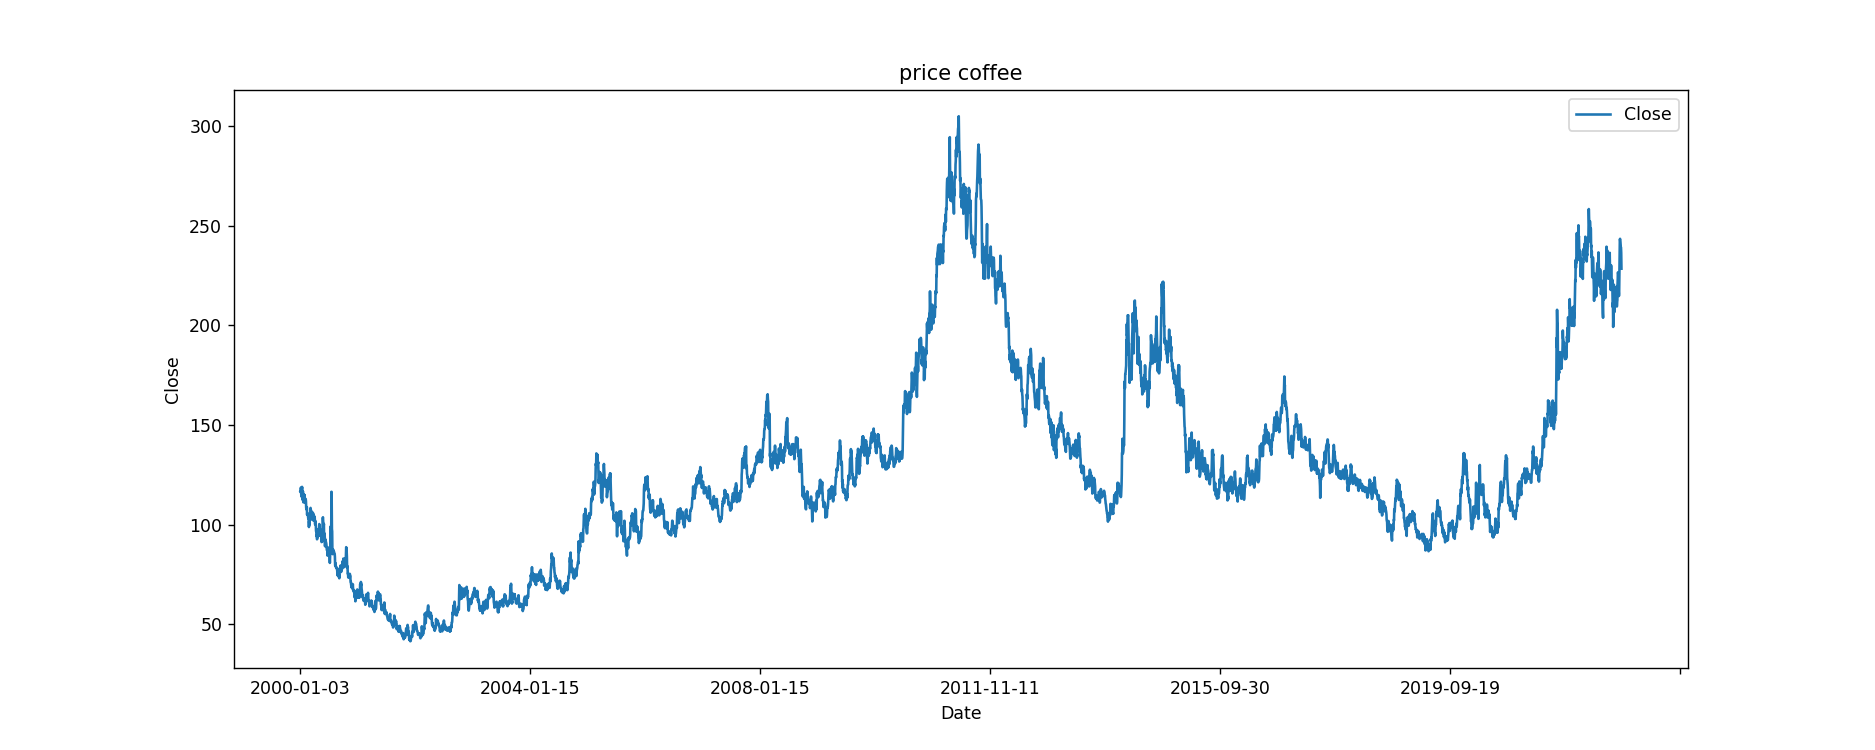

In [223]:
df.plot(x = "Date", y= "Close", figsize=(15, 6))
plt.title(f'price coffee')
plt.xlabel('Date')
plt.ylabel("Close")
plt.show()

### 9.2 Preparación de los datos para la red

nos quedamos con la variable 'Close' y armamos nuesta serie para poder pre-procesarla para la red

In [229]:
df.Date = pd.to_datetime(df.Date,yearfirst=True)
df.set_index('Date',inplace=True)
df = df.asfreq('b','ffill')

In [230]:
df_1 = df.Close.resample('M').mean()


In [398]:
df_1

Date
2000-01-31    115.059524
2000-02-29    106.373810
2000-03-31    104.636957
2000-04-30     96.600000
2000-05-31     97.032609
                 ...    
2022-05-31    218.599091
2022-06-30    230.172727
2022-07-31    216.066667
2022-08-31    224.221739
2022-09-30    232.385000
Freq: M, Name: Close, Length: 273, dtype: float64

Pasamos el dataset a float32 y normalizamos de 0 a 1.

In [482]:
dataset = df_1.values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

In [483]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Dividimos el dataset para entrenamiento y test

In [563]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

191 82


Creamos una función que tiene dos argumentos: el dataset y un look back que es el número de pasos hacia atrás que se toman en cuenta para hacer la predicción del paso siguiente.

In [647]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Elijo el tamaño de la ventana deslizante. Teniendo en cuenta el periodograma y viendo que tengo dos ciclos marcados (cada 12 puntos y cada 3 puntos) elijo una ventana deslizante de 3 que no es demasiado grande puede capturar los ciclos dentro de la serie.

In [660]:
look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [661]:
X_train.shape

(187, 3)

In [662]:
Y_train.shape

(187,)

Podemos ver como acabamos de construir un dataset que a cada 3 paso de X se "predice" 1 paso en Y. 

In [663]:
# reshape input to be [samples, time steps, features]

X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

In [664]:
X_train.shape

(187, 1, 3)

In [665]:
Y_train.shape

(187,)

### 9.3 Creación de la red neuronal

#### 9.3.1 Modelo 1

In [424]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back),  return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 1, 128)            67584     
                                                                 
 dropout_88 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_63 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_89 (Dropout)        (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dropout_90 (Dropout)        (None, 32)                0         
                                                                 
 dense_63 (Dense)            (None, 1)               

In [539]:
hist = model.fit(X_train, Y_train, epochs=10, batch_size=1, validation_split=0.2)

Epoch 1/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0038 - rmse: 0.0616 - val_loss: 0.0035 - val_rmse: 0.0592
Epoch 2/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0053 - rmse: 0.0731 - val_loss: 0.0033 - val_rmse: 0.0575
Epoch 3/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0042 - rmse: 0.0648 - val_loss: 0.0039 - val_rmse: 0.0621
Epoch 4/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0032 - rmse: 0.0568 - val_loss: 0.0038 - val_rmse: 0.0619
Epoch 5/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0034 - val_rmse: 0.0586
Epoch 6/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0030 - val_rmse: 0.0544
Epoch 7/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0078 - rmse: 0.0884 - val_loss: 0.0116 - val_rmse: 0.1078
Epoch 8/10
149/149 [==============================] - 0s 3ms/s

In [540]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

3/3 [==============================] - 0s 2ms/step


Tenemos que "desnormalizar" los datos para poder hacer predicciones en la misma escala de los datos originales.

In [541]:
trainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([Y_test])

Calculamos el RMSE tanto para Train como para Test

In [542]:
trainScore = np.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.76 RMSE
Test Score: 10.96 RMSE


<IPython.core.display.Javascript object>


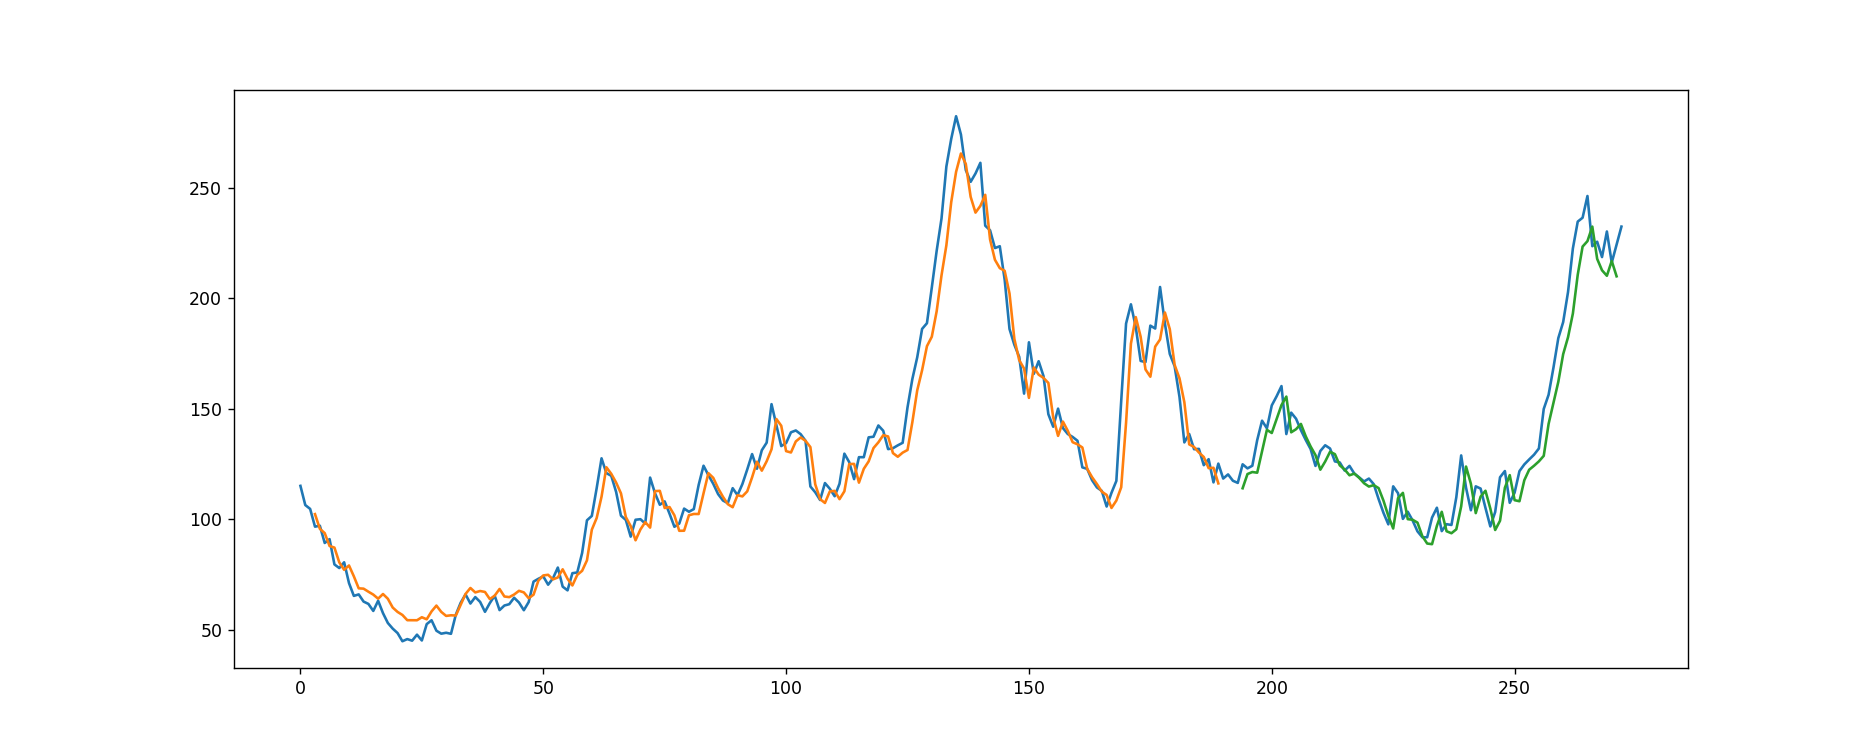

In [543]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict 
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(15,6))
fig = plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


<IPython.core.display.Javascript object>


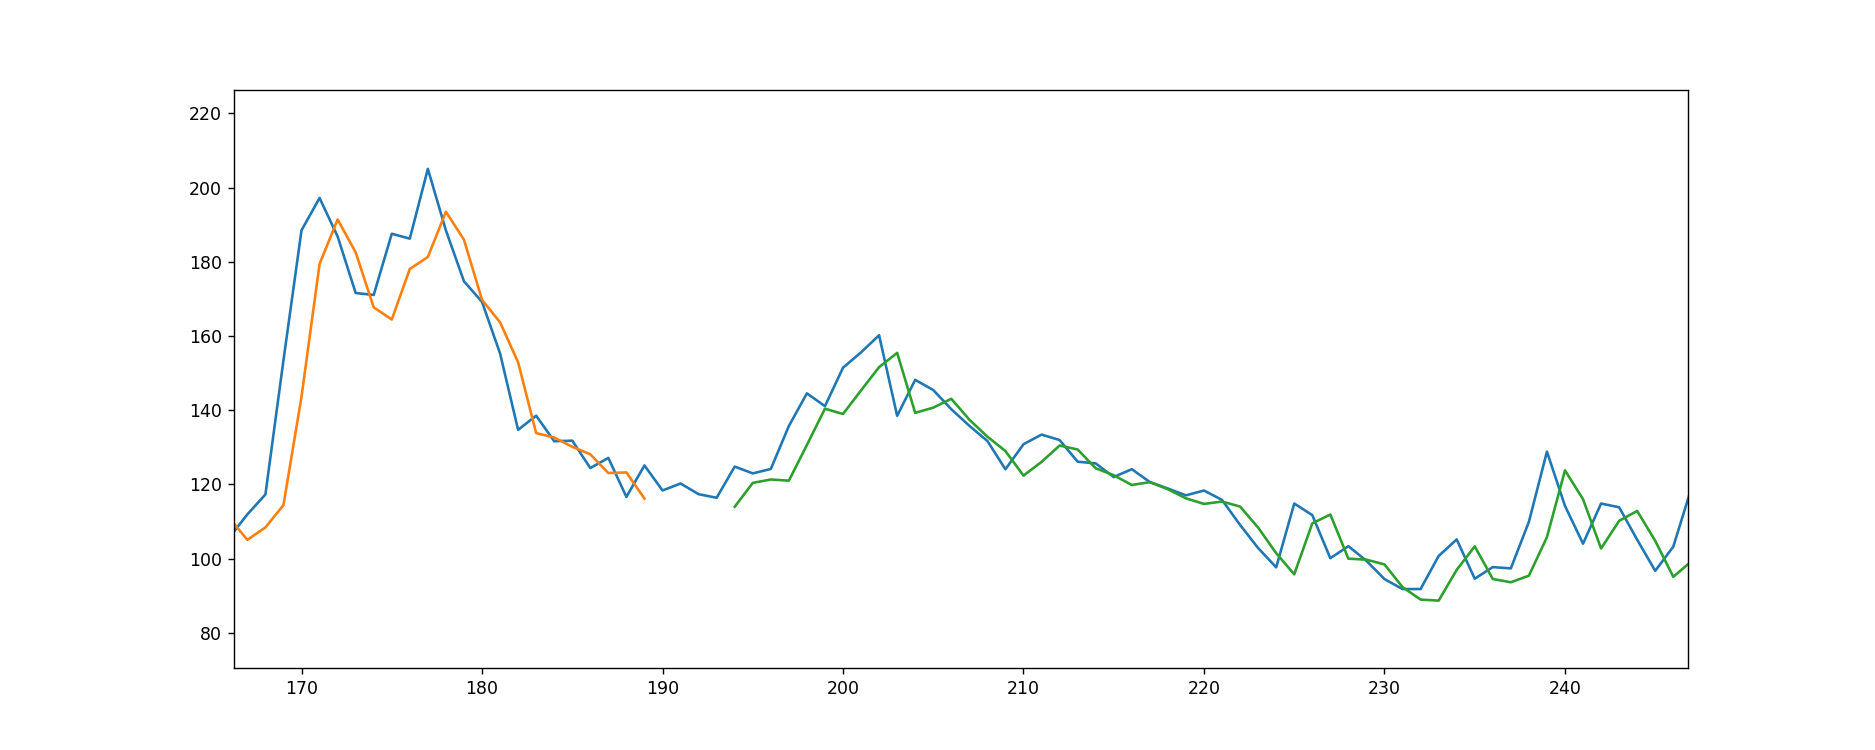

In [544]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict 
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(15,6))
fig = plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


Graficamos la Loss

<IPython.core.display.Javascript object>


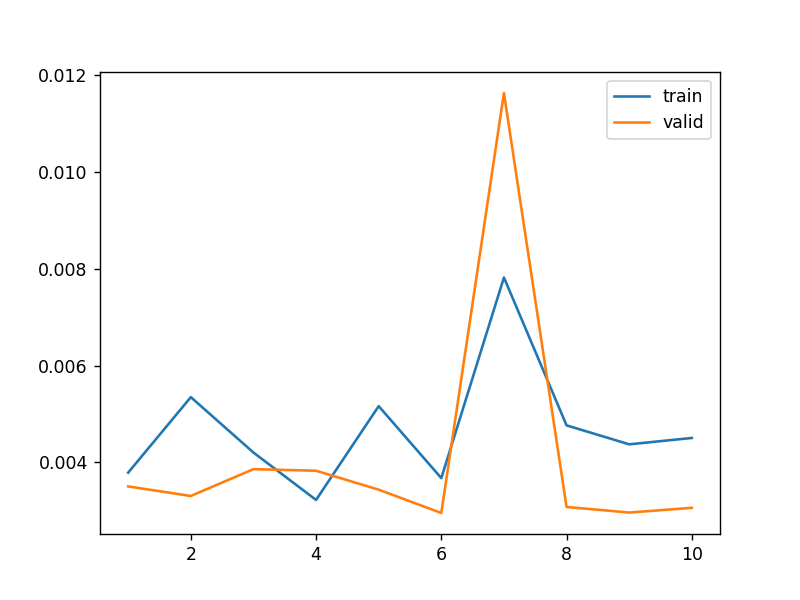

In [545]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

#### 9.3.2 Modelo 2

Probamos un segundo modelo

In [571]:
model_2 = Sequential()
model_2.add(LSTM(64, input_shape=(1, look_back),  return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=32))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=16, activation='relu'))
model_2.add(Dropout(rate=0.3))
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model_2.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 1, 64)             17408     
                                                                 
 dropout_101 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_74 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_102 (Dropout)       (None, 32)                0         
                                                                 
 dense_73 (Dense)            (None, 16)                528       
                                                                 
 dropout_103 (Dropout)       (None, 16)                0         
                                                                 
 dense_74 (Dense)            (None, 1)               

In [555]:
hist_2 = model_2.fit(X_train, Y_train, epochs=10, batch_size=1, validation_split=0.2)

Epoch 1/10
149/149 [==============================] - 3s 6ms/step - loss: 0.0635 - rmse: 0.2520 - val_loss: 0.0184 - val_rmse: 0.1356
Epoch 2/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0163 - rmse: 0.1276 - val_loss: 0.0054 - val_rmse: 0.0734
Epoch 3/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0086 - rmse: 0.0929 - val_loss: 0.0062 - val_rmse: 0.0790
Epoch 4/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0158 - rmse: 0.1258 - val_loss: 0.0051 - val_rmse: 0.0716
Epoch 5/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0115 - rmse: 0.1073 - val_loss: 0.0050 - val_rmse: 0.0709
Epoch 6/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0109 - rmse: 0.1046 - val_loss: 0.0048 - val_rmse: 0.0691
Epoch 7/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0109 - rmse: 0.1043 - val_loss: 0.0066 - val_rmse: 0.0813
Epoch 8/10
149/149 [==============================] - 0s 2ms/s

In [556]:
trainPredict = model_2.predict(X_train)
testPredict = model_2.predict(X_test)

3/3 [==============================] - 0s 2ms/step


In [557]:
trainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([Y_test])

In [558]:
trainScore = np.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.18 RMSE
Test Score: 11.16 RMSE


<IPython.core.display.Javascript object>


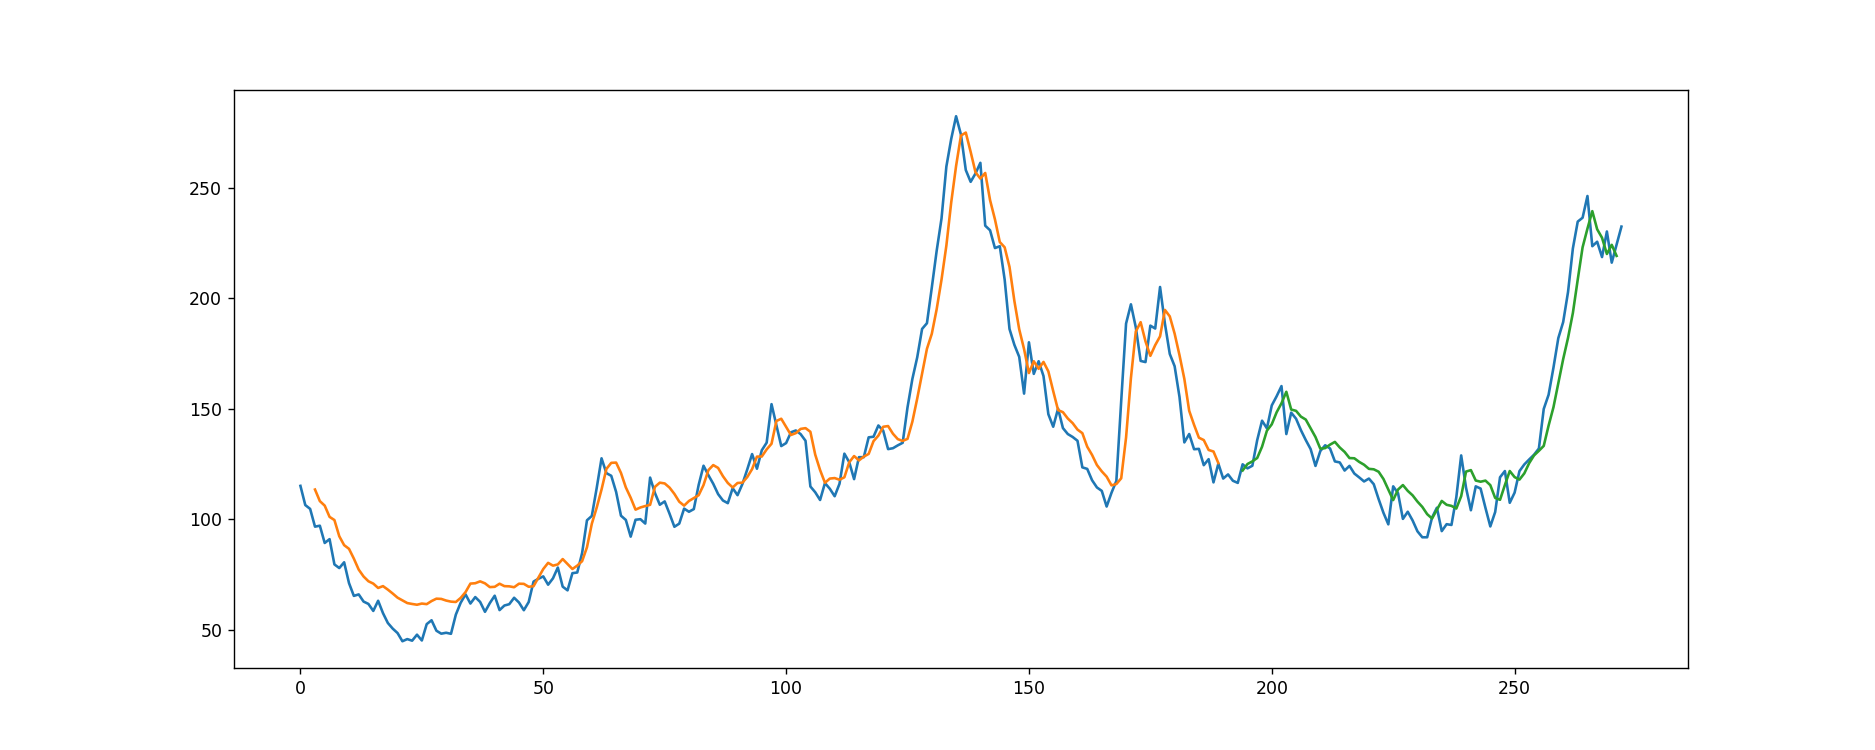

In [559]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(15,6))
fig = plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<IPython.core.display.Javascript object>


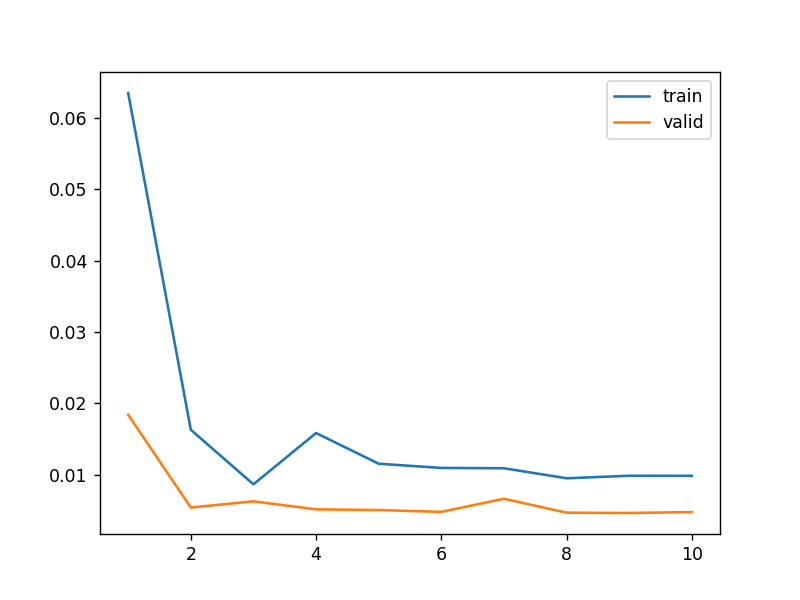

In [560]:
epoch_count = range(1, len(hist_2.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist_2.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist_2.history['val_loss'], label='valid')
plt.show()

#### 9.3.3 Modelo 3

Entrenamos un modelo más sencillo con menos epochs de entrenamiento porque vemos que en los casos anteriores estamos teniendo un overfitting. 

In [666]:
model_3 = Sequential()
model_3.add(LSTM(120, input_shape=(1, look_back)))
model_3.add(Dropout(0.2))
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model_3.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 120)               59520     
                                                                 
 dropout_108 (Dropout)       (None, 120)               0         
                                                                 
 dense_79 (Dense)            (None, 1)                 121       
                                                                 
Total params: 59,641
Trainable params: 59,641
Non-trainable params: 0
_________________________________________________________________


In [667]:
hist_3 = model_3.fit(X_train, Y_train, epochs=10, batch_size=1, validation_split=0.2)

Epoch 1/10
149/149 [==============================] - 2s 4ms/step - loss: 0.0364 - rmse: 0.1909 - val_loss: 0.0062 - val_rmse: 0.0790
Epoch 2/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0056 - rmse: 0.0746 - val_loss: 0.0063 - val_rmse: 0.0796
Epoch 3/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0035 - rmse: 0.0595 - val_loss: 0.0056 - val_rmse: 0.0746
Epoch 4/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0063 - val_rmse: 0.0791
Epoch 5/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0035 - rmse: 0.0593 - val_loss: 0.0053 - val_rmse: 0.0728
Epoch 6/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0052 - val_rmse: 0.0720
Epoch 7/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0033 - rmse: 0.0579 - val_loss: 0.0054 - val_rmse: 0.0733
Epoch 8/10
149/149 [==============================] - 0s 2ms/s

In [668]:
trainPredict = model_3.predict(X_train)
testPredict = model_3.predict(X_test)

3/3 [==============================] - 0s 2ms/step


In [669]:
trainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([Y_test])

In [670]:
trainScore = np.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
MAE = mean_absolute_error(Y_test[0], testPredict[:,0])
print('MAE: %.2f MAE' % (MAE))
MAPE = mean_absolute_percentage_error(Y_test[0], testPredict[:,0])
print('MAPE: %.2f MAPE' % (MAPE))

Train Score: 13.29 RMSE
Test Score: 10.72 RMSE
MAE: 8.93 MAE
MAPE: 0.07 MAPE


<IPython.core.display.Javascript object>


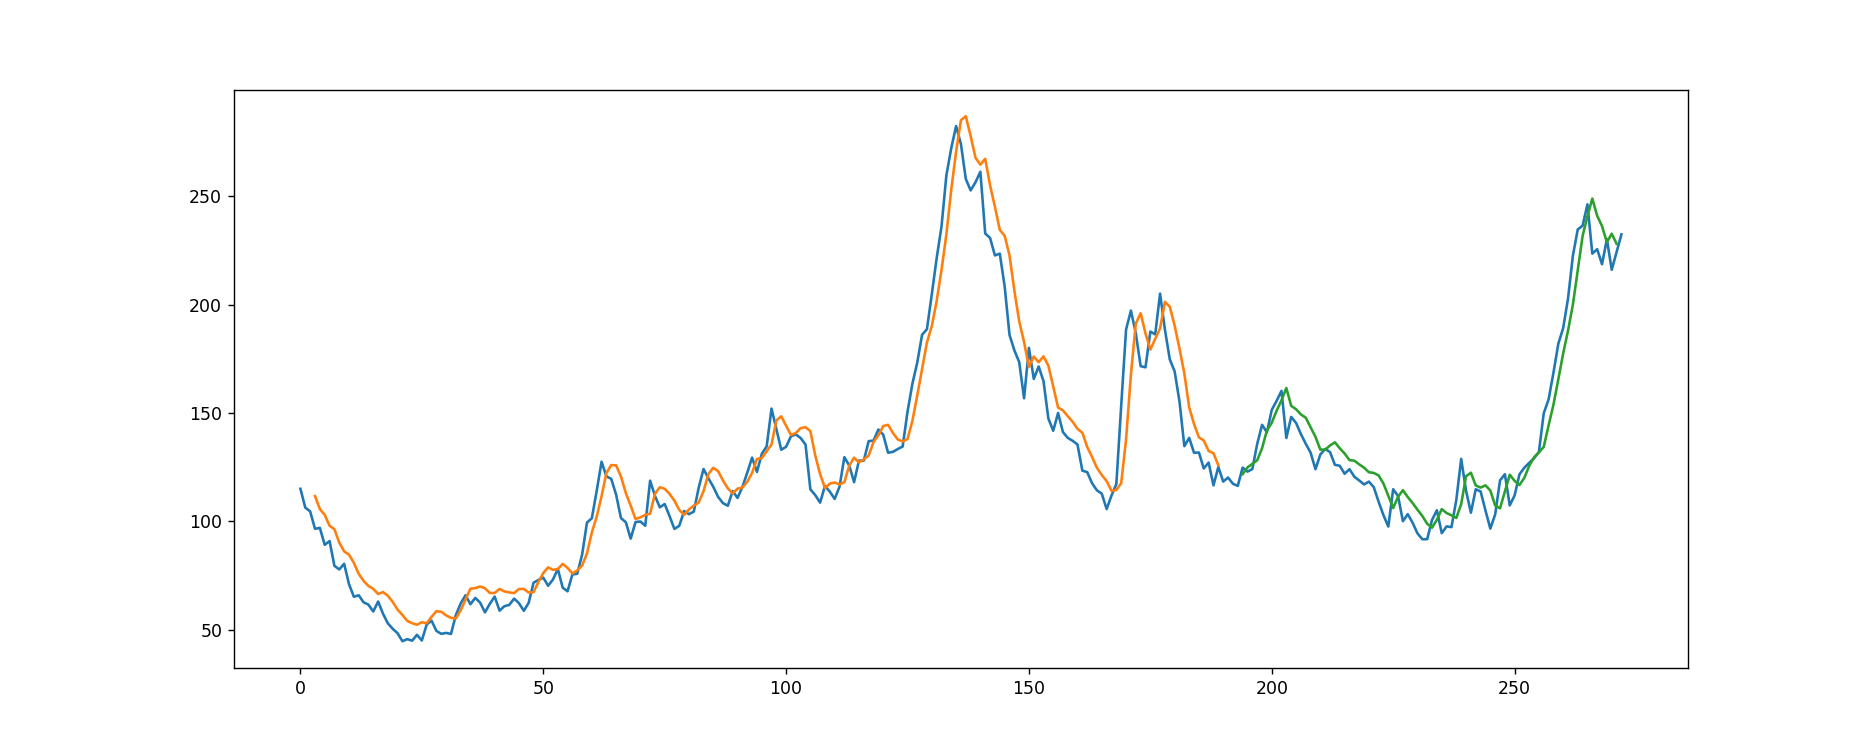

In [671]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(15,6))
fig = plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<IPython.core.display.Javascript object>


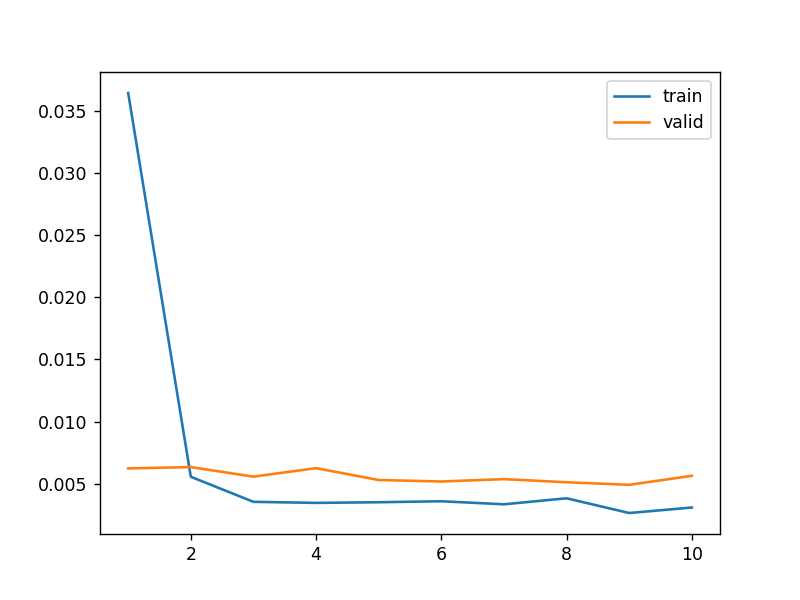

In [672]:
epoch_count = range(1, len(hist_3.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist_3.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist_3.history['val_loss'], label='valid')
plt.show()

### 9.4 Conclusión:

Tenemos dos redes que tienen el siguiente RMSE:

|Modelo | Train RMSE | Test RMSE |
|:-------:|:---:|:---:|
|1 | 10.76 |10.96|
|2 | 13.18 |11.16 |
|3|   13.29|  10.72   |


Lo que podemos concluir es que el tercer modelo que es un poco menos complejo tiene una mejor performance con los datos, obteniendo un error menor.

## 10. Comparación de modelos (S)ARIMA y LSTM

Haremos la comparación de las métricas de los siguientes modelos:

-(S)ARIMA: p=0, d=1, q=2 P=1 D=1 Q=1 s=12

-LSTM: imputs= 187, window=3, LSTM_layer=120, Dense_layer=1, epochs=10

|Modelo | MAE | MAPE | RSME|
|:-------:|:---:|:---:|:---:|
|(S)ARIMA | 29.87 | 0.20 | 40.89  |
|LSTM| 8.93|0.07  | 10.72 |


## 11. Conclusiones

-Para este problema particular puede ser que la red neuronal se ajuste mejor. Dado que el precio del café requiere de un seguimiento día a día, el ajuste punto a punto que tiene la red neuronal es mucho más preciso.

-El modelo (S)ARIMA nos arroja información importante si lo que se busca es conocer el comportamiento a largo plazo del precio. Es un modelo mucho más económico computacionalmente que arroja información suficiente si nos interesa predecir la tendencia. 

-Para la red neuronal siempre será importante la cantidad de datos, en ese caso ante una posible falta de datos, el modelo (S)ARIMA sigue siendo una buena fuente de información.